In [1]:
# IMAGE CONFIGURATIONS
# The original size of images are (600, 800). We'll take 512 x 512, which are both smaller than original size: act as a form of data augmentation
IMAGE_SIZE = [512, 512] 

# TRAINING CONFIGURATIONS
epochs = 10
batch_size = 128

## Preparing Data

In [2]:
import pandas as pd
df_train_data = pd.read_csv("../data/train_images_filtered_no_duplicates.csv")
df_train_data

,image_id,labels
0,723977410.jpg,3
1,3193577634.jpg,1
2,3349107107.jpg,3
3,2933959901.jpg,0
4,3020460837.jpg,4
...,...,...
26280,1778392170.jpg,2
26281,2495608764.jpg,3
26282,698646619.jpg,4
26283,297559984.jpg,3


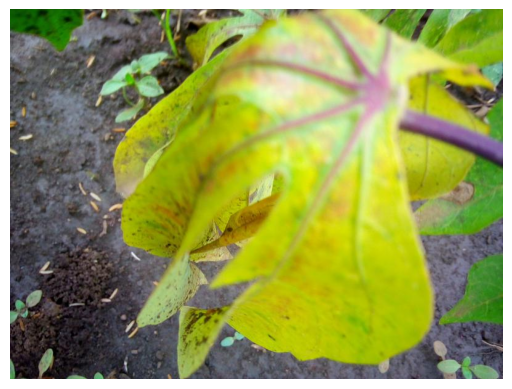

In [3]:
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt


import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
from torchvision import transforms

# Define the path to your train_images directory
train_path = "../data/train_images/"

# Use glob to get all image files with .jpg or .jpeg extensions
image_files = glob(train_path + '/*.jp*g')

# Define the transformation (ToTensor)
transform = transforms.ToTensor()

# Randomly select an image path
img_path = np.random.choice(image_files)

# Open the image
image = Image.open(img_path)

# Apply the transform to convert the image to a tensor
image_tensor = transform(image)

# Display the image
plt.imshow(image_tensor.permute(1, 2, 0))  # Permute is needed to change the shape to (H, W, C)
plt.axis('off')  # Hide axis
plt.show()

In [4]:
unique_labels = df_train_data.labels.value_counts()
num_unique_labels = unique_labels.nunique()


In [5]:
from sklearn import model_selection
df_train, df_valid = model_selection.train_test_split(df_train_data, test_size=0.2, random_state=109, stratify=df_train_data["labels"].values)
df_train.reset_index(drop=True, inplace=True)
df_valid.reset_index(drop=True, inplace=True)

In [6]:
from torch.utils.data import Dataset
import os 
import cv2
class ConstDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['image_id'].values
        self.labels = df['labels'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = os.path.join(train_path, file_name)
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        return image, label

In [7]:
proc_resize = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(size = IMAGE_SIZE)
        ])
train_df = ConstDataset(df_train, transform=proc_resize)

In [8]:
import torch 
trainloader = torch.utils.data.DataLoader(train_df, batch_size,
                                          shuffle=True, num_workers=0)

In [9]:
from tqdm import tqdm
def calc_mean_std(train_df, trainloader): 
    psum    = torch.tensor([0.0, 0.0, 0.0])
    psum_sq = torch.tensor([0.0, 0.0, 0.0])
    
    for input_image,_ in tqdm(trainloader):
        psum    += input_image.sum(axis        = [0, 2, 3])
        psum_sq += (input_image ** 2).sum(axis = [0, 2, 3])

    count = len(train_df) * IMAGE_SIZE[0] * IMAGE_SIZE[1]   
    total_mean = psum / count
    total_var  = (psum_sq / count) - (total_mean ** 2)
    total_std  = torch.sqrt(total_var)

    mean = total_mean.numpy()
    std = total_std.numpy()
    return (mean, std)
calc_mean, calc_std = calc_mean_std(train_df, trainloader)

100%|██████████| 185/185 [01:42<00:00,  1.80it/s]


In [10]:
proc_aug = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size = IMAGE_SIZE),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Normalize(mean=calc_mean,std=calc_std)
])

In [11]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

desired_majority_class_size = 6000

class_counts = df_train["labels"].value_counts()
undersample_strategy = {class_counts.idxmax(): desired_majority_class_size}

rus = RandomUnderSampler(sampling_strategy=undersample_strategy, random_state=109)
X_under, y_under = rus.fit_resample(
    df_train["image_id"].values.reshape(-1, 1), df_train["labels"].values
)

desired_minority_class_size = 6000

ros = RandomOverSampler(
    sampling_strategy={
        label: desired_minority_class_size
        for label in class_counts.index
        if class_counts[label] < desired_minority_class_size
    },
    random_state=109,
)
X_resampled, y_resampled = ros.fit_resample(X_under, y_under)

df_train_resampled = pd.DataFrame(
    {"image_id": X_resampled.flatten(), "labels": y_resampled}
)

# Check the new class distribution
print(df_train_resampled["labels"].value_counts())

df_train_resampled.reset_index(drop=True, inplace=True)

labels
0    6000
1    6000
2    6000
3    6000
4    6000
Name: count, dtype: int64


In [12]:
train_df = ConstDataset(df_train_resampled, transform=proc_aug)
valid_df = ConstDataset(df_valid, transform=proc_aug)

In [13]:
dataloader = {'train': torch.utils.data.DataLoader(train_df, batch_size,
                                          shuffle=True, num_workers=0), 
              'val': torch.utils.data.DataLoader(valid_df, batch_size,
                                          shuffle=True, num_workers=0)}

## Training model

In [ ]:
import timm
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils import clip_grad_norm_


In [ ]:
# Hyperparameters for training loop
max_grad_norm = 1000
num_classes = 5
criterion = nn.CrossEntropyLoss()

In [ ]:
# class for custom RexNext 
class CustomResNext(nn.Module):
    def __init__(self, model_name='resnext50_32x4d', pretrained=True):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        n_features = self.model.fc.in_features
        self.model.fc = nn.Linear(n_features, num_classes)

    def forward(self, x):
        x = self.model(x)
        return x

In [ ]:
#Initialize model and optimizer 
model = CustomResNext()
model = model.to(device)
optimizer = Adam(model.parameters(), lr=1e-4, weight_decay=1e-6)
scheduler = ReduceLROnPlateau(optimizer, mode = 'min', factor = 0.2, patience = 0.5, verbose = True, eps = 1e-6)

In [18]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    for phase in ['train', 'val']:
        if phase == 'train':
            resnext.train()
        else:
            resnext.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloader[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = resnext(inputs)  
            with torch.set_grad_enabled(phase == 'train'):
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    
                    grad_norm = clip_grad_norm_(model.parameters(), max_grad_norm)
                    
                    optimizer.step()
                    optimizer.zero_grad()
                    

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels)

        if phase == 'train': 
            epoch_loss = running_loss / len(train_df)
            epoch_acc = running_corrects.double() / len(train_df)
        else: 
            epoch_loss = running_loss / len(valid_df)
            epoch_acc = running_corrects.double() / len(valid_df)

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

print("Training complete!")

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 GiB. GPU 0 has a total capacity of 22.17 GiB of which 869.81 MiB is free. Process 1355824 has 16.34 GiB memory in use. Including non-PyTorch memory, this process has 4.72 GiB memory in use. Of the allocated memory 1.96 GiB is allocated by PyTorch, and 2.52 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)